<a href="https://colab.research.google.com/github/rrhkwk123/Work/blob/main/Module_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Note: After you run this cell, the training and test data will be available in
# the file browser. (Click the folder icon on the left to view it)
#
# If you don't see the data after the cell completes, click the refresh button
# in the file browser (folder icon with circular arrow)

# First, let's download and unzip the data
!echo "Downloading files..."
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test.zip

!echo "Unzipping files..."
!unzip -q /content/training1.zip
!unzip -q /content/training2.zip
!unzip -q /content/test.zip

# Combine the two traning directories
!echo "Mergining training data..."
!mkdir /content/training
!mv /content/training1/* /content/training
!mv /content/training2/* /content/training

# Cleanup
!echo "Cleaning up..."
!rmdir /content/training1
!rmdir /content/training2
!rm training1.zip
!rm training2.zip
!rm test.zip

!echo "Data ready."

Unzipping files...
replace training1/00009/00043_00015.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace training1/00009/00004_00018.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
replace training2/00031/00004_00018.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
replace test/04354.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Mergining training data...
mkdir: cannot create directory ‘/content/training’: File exists
mv: cannot move '/content/training1/00000' to '/content/training/00000': Directory not empty
mv: cannot move '/content/training1/00001' to '/content/training/00001': Directory not empty
mv: cannot move '/content/training1/00002' to '/content/training/00002': Directory not empty
mv: cannot move '/content/training1/00003' to '/content/training/00003': Directory not empty
mv: cannot move '/content/training1/00004' to '/content/training/00004': Directory not empty
mv: cannot move '/content/training1/00005' to '/content/training/00005': Directory not empty
mv: cannot move '/content

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [ ]:
# Create an image training dataset
from tensorflow.keras.preprocessing import image_dataset_from_directory

# We're using keras' image_dataset_from_directory method to load our image data.
# See (https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) for details
#
# A couple of things to note:
# 1. We're specifying a number for the seed, so we'll always get the same shuffle and split of our images.
# 2. Class names are inferred automatically from the image subdirectory names.
# 3. We're splitting the training data into 80% training, 20% validation. 


training_dir = '/content/training/'
image_size = (100, 100)

# Split up the training data images into training and validations sets
training_data = image_dataset_from_directory(training_dir, validation_split=.2, subset='training', seed=42, image_size=image_size)
test_data = image_dataset_from_directory(training_dir, validation_split=.2, subset='validation', seed=42, image_size=image_size)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


In [ ]:
# Get the class names for the training data
class_names = training_data.class_names
print(class_names)

['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042']


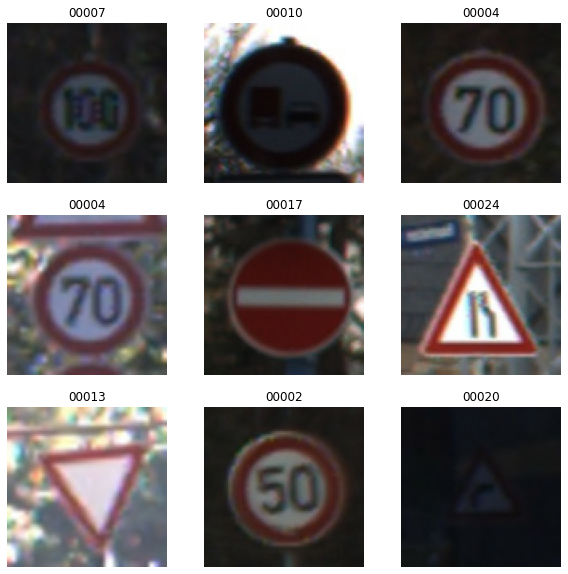

In [ ]:
# View first 9 images and their class labels
plt.figure(figsize=(10, 10))
for images, labels in training_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(training_data.class_names[labels[i]])
    plt.axis("off")

In [ ]:
# Configure the datasets for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = training_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = test_data.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Create additional image permutations to allow for more use cases and therefore better image recognition.
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(100, 
                                                              100,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

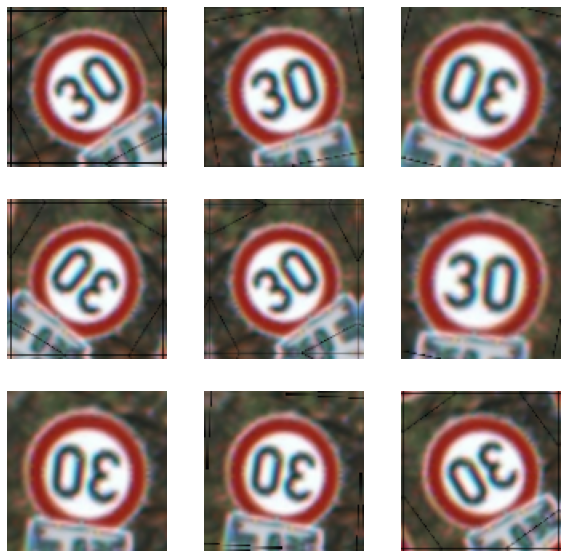

In [ ]:
# Look at the first image as an example
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Build the Model

In [ ]:
# Build a model...
number_of_classes = 43
image_shape = (100, 100, 3)
model = Sequential([
  data_augmentation, # Add in the augmentation layer
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=image_shape), # Rescale the RGB values to between 0 & 1
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(number_of_classes)
])

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 100, 100, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 25, 25, 64)       

In [ ]:
# Fit the model
number_of_epochs = 10

history = model.fit(train_ds, epochs=number_of_epochs, validation_data=val_ds)

Epoch 1/10
981/981 [==============================] - 20s 20ms/step - loss: 1.6372 - accuracy: 0.5035 - val_loss: 0.7107 - val_accuracy: 0.7777
Epoch 2/10
981/981 [==============================] - 7s 7ms/step - loss: 0.5785 - accuracy: 0.8168 - val_loss: 0.2581 - val_accuracy: 0.9286
Epoch 3/10
981/981 [==============================] - 7s 7ms/step - loss: 0.3500 - accuracy: 0.8852 - val_loss: 0.1845 - val_accuracy: 0.9425
Epoch 4/10
981/981 [==============================] - 7s 7ms/step - loss: 0.2619 - accuracy: 0.9157 - val_loss: 0.1360 - val_accuracy: 0.9578
Epoch 5/10
981/981 [==============================] - 7s 7ms/step - loss: 0.2163 - accuracy: 0.9310 - val_loss: 0.1113 - val_accuracy: 0.9653
Epoch 6/10
981/981 [==============================] - 7s 7ms/step - loss: 0.1850 - accuracy: 0.9414 - val_loss: 0.1020 - val_accuracy: 0.9710
Epoch 7/10
981/981 [==============================] - 7s 7ms/step - loss: 0.1660 - accuracy: 0.9462 - val_loss: 0.0898 - val_accuracy: 0.9717
Epoc

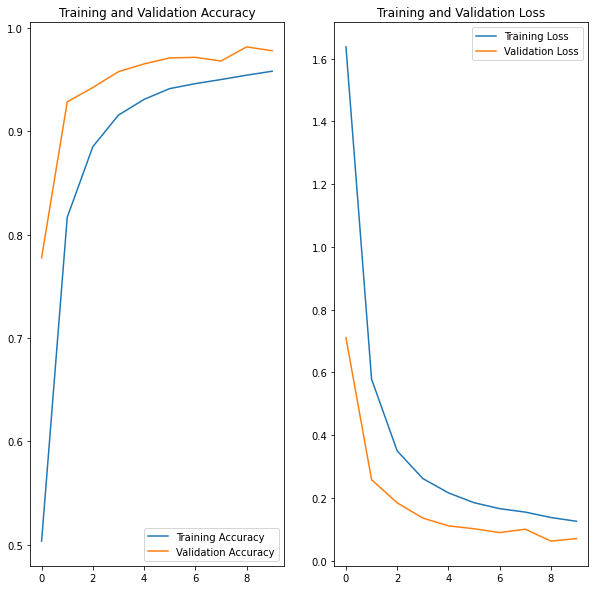

In [ ]:
# Graph the accuray and loss of the training and validation data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Read in the test data and create a new blank column for the prediciton score
test_csv = pd.read_csv('/content/test/test_classes.csv')
test_csv['PredictionId'] = ''
test_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12630 entries, 0 to 12629
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Filename      12630 non-null  object
 1   ClassId       12630 non-null  int64 
 2   PredictionId  12630 non-null  object
dtypes: int64(1), object(2)
memory usage: 296.1+ KB


In [ ]:
# Loop through CSV and predict the image category
for index, row in test_csv.iterrows():
  file_name = row['Filename']
  print("Processing file " + file_name + "...\n")
  file_path = '/content/test/' + file_name
  img = keras.preprocessing.image.load_img(
    file_path, target_size=(100, 100)
  )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)
  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  test_csv[test_csv['Filename'] == file_name]['PredictionId'] = class_names[np.argmax(score)].lstrip("0")

test_csv.head()

Processing file 00000.jpg...

16


In [ ]:
# Write file to CSV
test_csv.to_csv(path_or_buf='/content/results.csv')

from google.colab import files

# Download file locally to play with in Excel
files.download('/content/results.csv')

In [ ]:
# Check for the number of incorrect predictions
count_wrong = 0

test_csv.loc[test_csv['ClassId'] == 0, 'PredictionId'] = 0

test_csv.loc[test_csv['ClassId'] == 0]

for index, row in test_csv.iterrows():
    if row['ClassId'] == row['PredictionId']:
      count_wrong += 1

count_wrong

60